In [1]:
#imports

import shlex, subprocess
import os , sys
import time

import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow import keras
import keras_tuner

from Bio import SeqIO
from pybedtools import BedTool

import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns    

2023-03-14 09:25:49.537249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 09:26:03.248180: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#one hot encoding
def fasta_to_onehotencode(seq) : 
    #values = list(seq)
    #values = np.array(values)
    base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    # label = int(line.strip()[1])
    
    
    sequence = seq 
    # Encode sequence bases as integers, i.e. A as 0, C as 1, etc.
    sequence_int = [base2int.get(base, 9999) for base in sequence]
    
    sequence_onehot = tf.one_hot(sequence_int, depth=4)
    
        
    return sequence_onehot

In [3]:
def fastatoarray(fasta_sequences) :
    seq_array = np.zeros((1,400,4)) 
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        new_sequence = fasta_to_onehotencode(sequence) #onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))
    seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 
    return seq_array  

In [4]:
def get_df_m6A(path,file): 
            
        m6A = BedTool(path+ '/'+file)
        df_m6A = m6A.to_dataframe(disable_auto_names=True, names = [i for i in range(19)])
        df_m6A['abs_pos'] = df_m6A[1] - df_m6A[14] #getting the absolute position of the m6A site in the sequence
        return df_m6A

In [5]:
def m6A_onehot(path,file,df_m6A): 
    
    onehot_m6A_seq = np.zeros((1,400,5))
    m6A_file = np.zeros((1,400,1))
    seq_array = np.zeros((1,400,4)) 


    fasta_sequences = SeqIO.parse(open(path+ '/'+file),'fasta')
    

    for fasta in fasta_sequences:

        name, sequence = fasta.id, str(fasta.seq)

        chrom = str(name).split(':')[0]
        start = (str(name).split(':')[1]).split('-')[0]
        end=((str(name).split(':')[1]).split('-')[1]).split('(')[0]

        #filtering for the sequences which contain an m6A site
        filtered = df_m6A.loc[((df_m6A[13] == chrom) & (df_m6A[14] == int(start)) & (df_m6A[15] == int(end)))] 
        
        #one hot encoding the sequence
        new_sequence = fasta_to_onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))

        m6A_seq= np.zeros((1,400,1)) #standard m6A column
        if filtered.empty == False :
            
            #print( 'this is filtered' )
            #print(len(filtered))
            #print(filtered)
            for i in filtered.index:
                index = filtered.loc[i, 'abs_pos'] -1 
                m6A_seq[0][index] = 1 #substituting with 1 in the m6A site 
            #print(m6A_seq.shape)
        m6A_file = np.vstack((m6A_file, m6A_seq)) 


    m6A_file = np.delete(m6A_file, 0, 0)
    #print(m6A_file.shape)
    seq_array = np.delete(seq_array, 0, 0) 
    #print(seq_array.shape)

    onehot_m6A_seq = np.c_[seq_array, m6A_file]
    #print(onehot_m6A_seq.shape) # the shape needs to be addressed 
    #onehot_m6A_seq = np.delete(onehot_m6A_seq,0,0)
    #print(onehot_m6A_seq.shape)

    return onehot_m6A_seq


In [6]:
#

def getonehotencoded_files_pos(path): 
    
    directory3 = os.listdir(path) #--> fol0,fold1....
    
    #here outside merging all diff files
    df_pos =pd.DataFrame() 
    df_pos_aug =pd.DataFrame() 
    
    positive_m6A = np.zeros((1,400,5))

    for file in directory3 : #all files
         if '.miclip.filt.bed.out' in file : 
            if ('positive' in file) and ('slop' not in file ):
                df_pos = get_df_m6A(path,file) 
            if ('positive' in file) and ('slop' in file ):
                df_pos_aug = get_df_m6A(path,file) 
        

    for file in directory3 :
        #print(file)

        if 'fasta' in file : 
            if ('positive' in file) and ('out' not in file ):
                #print('positive')
                positive_m6A = np.vstack((positive_m6A,m6A_onehot(path,file,df_pos )))  
                #print(positive_m6A.shape)
             
            if ('positive' in file) and ('out' in file ):
                #print('positive')
                positive_m6A = np.vstack((positive_m6A, m6A_onehot(path,file,df_pos_aug )))  
                #print(positive_m6A.shape)
                
    positive_m6A = np.delete(positive_m6A, 0, 0)  

    return positive_m6A #for one fold 



In [7]:
def getonehotencoded_files_neg(path, folder):
    
    directory3 = os.listdir(path) #files
    
    #here outside merging all diff files
    df =pd.DataFrame() 
    neg_m6A = np.zeros((1,400,5))
    


    for file in directory3 :
            if ((file.__contains__('.miclip.filt.bed.out')) & (file.__contains__(folder))): 
                df = get_df_m6A(path,file)
                #print(len(df))
            
                
    for file in directory3 :
        #print(file)

        if ((file.__contains__(folder)) & (file.__contains__('fa'))):
            #print(file)
            
            neg_m6A = m6A_onehot(path,file,df )
            #print(neg_m6A.shape)


    return neg_m6A #for one fold 


    
    
    
    
    
    

In [8]:
def prepare_raw_dataset_m6A(path, current_folder) : 
    print('Starting preparation of the dataset for %s' %current_folder)
    
    folder = current_folder #RBP
    directory2 = os.listdir(path+ '/' + folder)
    
    
    seq_list_pos = np.zeros((1,400,5))             
    seq_list_neg1 = np.zeros((1,400,5))

   

    seq_list_pos_test = np.zeros((1,400,5))             
    seq_list_neg1_test = np.zeros((1,400,5))
   

    for folder2 in directory2 :#fold0, fold1.... 
        directory3 = os.listdir(path+ '/' + folder + '/' + folder2)
        path_neg = '/lustre/groups/crna01/workspace/sofia/gencode/negatives/'  #directly in seq_list 
        
        if folder2 != "fold-4": #to be split into training and validation 
            #print(folder2)
            
            seq_list_pos_file = getonehotencoded_files_pos(path+ '/' + folder + '/' + folder2)#change just to positives
            seq_list_neg1_file = getonehotencoded_files_neg(path_neg+folder, folder2) 
            
            seq_list_neg1 = np.vstack((seq_list_neg1, seq_list_neg1_file))
            seq_list_pos = np.vstack((seq_list_pos, seq_list_pos_file))
            


        if folder2 == "fold-4":#for testing
            #print('fold4')
            
            seq_list_pos_test_file = getonehotencoded_files_pos(path+ '/' + folder + '/' + folder2) 
            seq_list_neg1_test_file = getonehotencoded_files_neg(path_neg+folder, folder2) 
            
            seq_list_neg1_test = np.vstack((seq_list_neg1_test, seq_list_neg1_test_file))
            seq_list_pos_test = np.vstack((seq_list_pos_test, seq_list_pos_test_file))

            #print(seq_list_pos.shape, seq_list_neg1.shape, seq_list_neg2.shape)
        
        
        
       
        
        
        
    seq_list_pos = np.delete(seq_list_pos, 0, 0)             
    seq_list_neg1 = np.delete(seq_list_neg1, 0, 0)
    
    
    #print(seq_list_pos.shape, seq_list_neg1.shape, seq_list_neg2.shape)
    #print(seq_list_pos_test.shape, seq_list_neg1_test.shape, seq_list_neg2_test.shape)

    seq_list_pos_test = np.delete(seq_list_pos_test, 0, 0)             
    seq_list_neg1_test = np.delete(seq_list_neg1_test, 0, 0)
    
    
    return seq_list_pos,seq_list_neg1,seq_list_pos_test,seq_list_neg1_test
    

In [9]:
#p, n , pt, nt = prepare_raw_dataset_m6A('/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/', 'AATF_K562')

In [10]:
#pt.shape

In [11]:
def filter_m6A_from_array(tot) :
    
    tot_filt = np.zeros((1,400,5))
    
    for array in tot : 
        #print(array.shape)
        if any(array[:,4]) : 
            #print('----')
            #print((array[:,4]))
            array = np.expand_dims(array, axis =0)
            tot_filt = np.vstack((tot_filt, array)) 
    
    
    tot_filt = np.delete(tot_filt, 0, 0)  
    #print(tot_filt.shape)
    return tot_filt

In [12]:
def settingA(pos, neg1, pos_t, neg1_t): 
    #
    
    #positive-a: bound and containing at least an m6a site
    #negative-1-a: un-bound and containing at least an m6a site
    #negative-2-a: bound by other proteins and containing at least an m6a site
    
    #positive, now filtering just for sequences that contain m6A sites

    
    pos_filt = filter_m6A_from_array(pos)  
    #print(pos_filt.shape)
    pos_t_filt = filter_m6A_from_array(pos_t)
    #print(pos_t_filt.shape)
    neg1_filt = filter_m6A_from_array(neg1)  
    neg1_t_filt = filter_m6A_from_array(neg1_t)
    #print(neg1_t_filt.shape)
    #neg2_filt = filter_m6A_from_array(neg2)  
    #neg2_t_filt = filter_m6A_from_array(neg2_t)
    #print('neg2_fold4')
    #print(neg2_t_filt.shape)
    
    
    #downsampling the negative set to match the positive one 
    
    neg1_filt = neg1_filt[:(len(pos_filt))]
    neg1_t_filt = neg1_t_filt[:(len(pos_t_filt))]
    
    
    
    #after the filtering, produce the labels
    labels_pos = np.ones((np.shape(pos_filt)[0], 1))
    #print(labels_pos.shape)
    labels_pos_t = np.ones((np.shape(pos_t_filt)[0], 1))
    
    labels_neg1 = np.zeros((np.shape(neg1_filt)[0], 1))
    labels_neg1_t = np.zeros((np.shape(neg1_t_filt)[0], 1))
    
    #labels_neg2 = np.zeros((np.shape(neg2_filt)[0], 1))
    #labels_neg2_t = np.zeros((np.shape(neg2_t_filt)[0], 1))
    
    return pos_filt, neg1_filt, pos_t_filt, neg1_t_filt, labels_pos, labels_neg1, labels_pos_t, labels_neg1_t 
    

In [13]:
#pos_filt, neg1_filt, pos_t_filt, neg1_t_filt, labels_pos, labels_neg1, labels_pos_t, labels_neg1_t  = settingA(p,n,pt,nt)

In [14]:
#neg1_t_filt.shape

In [15]:
def finalize_dataset(current_folder, pos, neg, pos_t, neg_t, labels_pos, labels_neg, labels_pos_t, labels_neg_t): 
    
    print('Shape of labels: \n-positive : ',np.shape(labels_pos),'\n-negative : ', np.shape(labels_neg),'\n-positive test : ',np.shape(labels_pos_t),'\n-negative test : ',np.shape(labels_neg_t))
    
    
    #merging datasets
    x = np.vstack((pos, neg))

    x_test = np.vstack((pos_t, neg_t))

    y = np.vstack((labels_pos, labels_neg))

    y_test = np.vstack((labels_pos_t, labels_neg_t))
    
    #creating the validation set

    #parameters 
    test_size = 0.2

    #test set

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, shuffle= True)
    x_test, y_test = shuffle(x_test, y_test, random_state=0)

    y_train = y_train.astype("float32")#actually useful?
    y_val =y_val.astype("float32")
    y_test = y_test.astype("float32")

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test =x_test.astype("float32")



    print('Shape of datasets: \n-training set : ',np.shape(x_train),'\n-validation set : ',np.shape(x_val),'\n-testing set : ', np.shape(x_test))
    
    #checking class ditribution in the whole dataset and training set

    print('Label frequencies among the dataset %s' %current_folder)
    plt.hist(y)
    plt.xticks(range(2))
    plt.title('Label Frequency')
    plt.show()

    plt.hist(y_train)
    plt.xticks(range(2))
    plt.title('Label Frequency training set')
    plt.show()

    plt.hist(y_val)
    plt.xticks(range(2))
    plt.title('Label Frequency validation set')
    plt.show()
    return x_train ,y_train ,x_val ,y_val ,x_test ,y_test

In [16]:
def create_baseline_model(input_shape):
    from tensorflow.keras.optimizers.legacy import Adam
    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve= 'ROC',name='auroc'),
      keras.metrics.AUC(curve = 'PR', name='auprc')  
    ]
   
    # inserting the best model hyperparameters keeping the input shape variable 
    
    
    #parameters 
    
  
    filters = 50
    kernel_size = 10
    pool_size = 10
    strides = 8
    learning_rate = 0.0007744959

    
    # create model
        
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape= input_shape))
    
    
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size, 
              kernel_initializer= 'random_uniform',                    
              activation='tanh'))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='same'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))
    

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer= 'random_uniform', 
              activation='tanh'))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='same'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters

    model.add(keras.layers.Dense(768, activation='tanh', use_bias = True, kernel_initializer = 'glorot_uniform'))
    model.add(keras.layers.Dense(256, activation='tanh',use_bias = True, kernel_initializer = 'glorot_uniform'))
    model.add(keras.layers.Dense(288, activation='tanh',use_bias = True, kernel_initializer = 'glorot_uniform'))
    model.add(keras.layers.Dense(10, activation='tanh',use_bias = True, kernel_initializer = 'glorot_uniform'))
    
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid',use_bias = True, kernel_initializer = 'glorot_uniform'))#what should be the output shape? 1? 

    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate) , metrics= METRICS) # for binary classification
    
    return model 


In [17]:
def training_model(model, class_weights, x_train ,y_train ,x_val ,y_val ,x_test ,y_test, folder) : 
    
    
    #class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train) #labels

    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve= 'ROC',name='auroc'),
      keras.metrics.AUC(curve = 'PR', name='auprc')  
    ]
    
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
    
    #fitting the model

    #model2 = keras.models.load_model('best_models/best_hps_model')


    history = model.fit(x_train, y_train, epochs=200, validation_data= (x_val,y_val), class_weight=class_weights, callbacks = my_callbacks)
    
    
    
    # list all data in history --> add name of the rbp!!!!

    print(history.history.keys())
    
    plt.title('Model evaluation for %s' %folder)
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy %s'  %folder)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss %s'  %folder)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for auroc 
    plt.plot(history.history['auroc'])
    plt.plot(history.history['val_auroc'])
    plt.plot(history.history['auprc'])
    plt.plot(history.history['val_auprc'])
    plt.title('model auroc and auprc %s'  %folder)
    plt.ylabel('auroc and auprc')
    plt.xlabel('epoch')
    plt.legend(['auroc_train', 'auroc_test','auprc_train', 'auprc_test'], loc='upper left')
    plt.show()
    
    
    model.save('best_models/best_model_settingA_new_aug%s' %folder)

In [18]:
def testing_model(path , current_folder, x_test, y_test) : 
    
    reconstructed_model = keras.models.load_model(path)
    
    y_pred = reconstructed_model.predict(x_test)

    threshold = 0.5

    y_pred2 = np.where(y_pred > threshold, 1,0)
    
    #Get the confusion matrix model1

    cf_matrix = confusion_matrix(y_test, y_pred2)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    #saving the true and predicted labels
    
    df= pd.DataFrame(y_pred, columns = ['Predictions'])
    df['True'] = y_test
    
    fpr, tpr, thresholds = metrics.roc_curve(df['True'], df['Predictions'], drop_intermediate=False)
    
    roc_auc = metrics.roc_auc_score(df['True'], df['Predictions'])
    

    # Generate figure
    fig = pl.figure(figsize=(14,7))
    ax = fig.add_subplot(121)

    pl.plot(fpr, tpr, label=" (AUC=%.2f)" % roc_auc)
    ax.plot([0,1], [0,1], color="grey",label="Random Classifier",linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.grid(color="#CCCCCC")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #rbp = str(file).split('.')[0]
    pl.title('AUROC %s' % current_folder)
    pl.legend()
    pl.tight_layout()
    

    #saving the predictions (0,1) in a csv file -- in probabilities 

    df.to_csv("predictions_A_new_aug/%s.csv" % current_folder)
    
    print("Prediction saved.")



Starting preparation of the dataset for RBM15_HepG2


2023-03-14 09:27:02.563191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 09:27:02.567476: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 09:27:02.567599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpusrv51.scidom.de): /proc/driver/nvidia/version does not exist
2023-03-14 09:27:02.620919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of labels: 
-positive :  (3800, 1) 
-negative :  (3800, 1) 
-positive test :  (957, 1) 
-negative test :  (957, 1)
Shape of datasets: 
-training set :  (6080, 400, 5) 
-validation set :  (1520, 400, 5) 
-testing set :  (1914, 400, 5)
Label frequencies among the dataset RBM15_HepG2


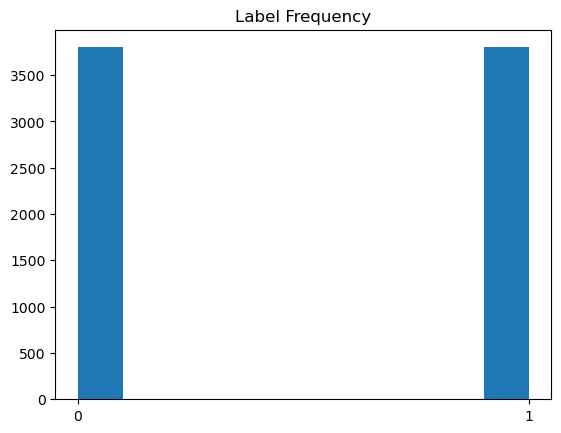

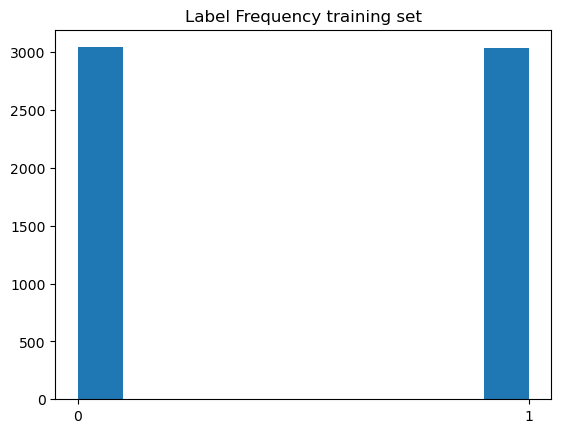

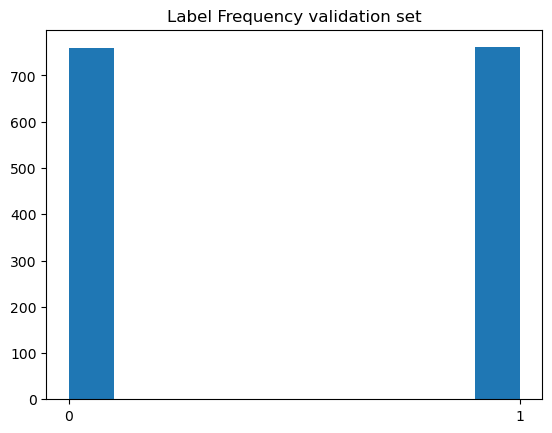

Epoch 1/200
190/190 [==============================] - 7s 10ms/step - loss: 0.6582 - tp: 1857.0000 - fp: 1157.0000 - tn: 1884.0000 - fn: 1182.0000 - accuracy: 0.6153 - precision: 0.6161 - recall: 0.6111 - auroc: 0.6630 - auprc: 0.6466 - val_loss: 0.4435 - val_tp: 719.0000 - val_fp: 283.0000 - val_tn: 476.0000 - val_fn: 42.0000 - val_accuracy: 0.7862 - val_precision: 0.7176 - val_recall: 0.9448 - val_auroc: 0.9169 - val_auprc: 0.9236
Epoch 2/200
190/190 [==============================] - 1s 5ms/step - loss: 0.2495 - tp: 2728.0000 - fp: 216.0000 - tn: 2825.0000 - fn: 311.0000 - accuracy: 0.9133 - precision: 0.9266 - recall: 0.8977 - auroc: 0.9605 - auprc: 0.9651 - val_loss: 0.0726 - val_tp: 736.0000 - val_fp: 3.0000 - val_tn: 756.0000 - val_fn: 25.0000 - val_accuracy: 0.9816 - val_precision: 0.9959 - val_recall: 0.9671 - val_auroc: 0.9958 - val_auprc: 0.9967
Epoch 3/200
190/190 [==============================] - 1s 5ms/step - loss: 0.1500 - tp: 2891.0000 - fp: 113.0000 - tn: 2928.0000 - 

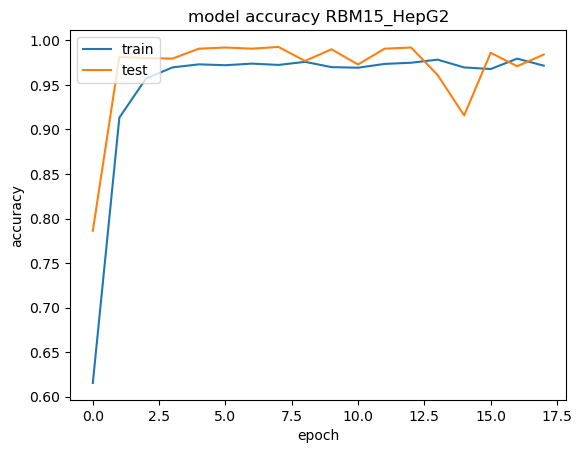

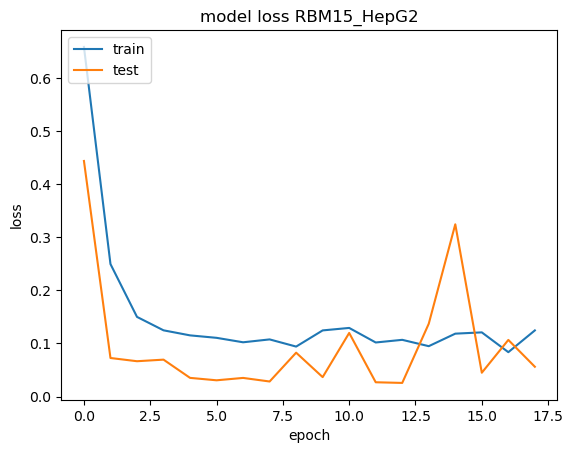

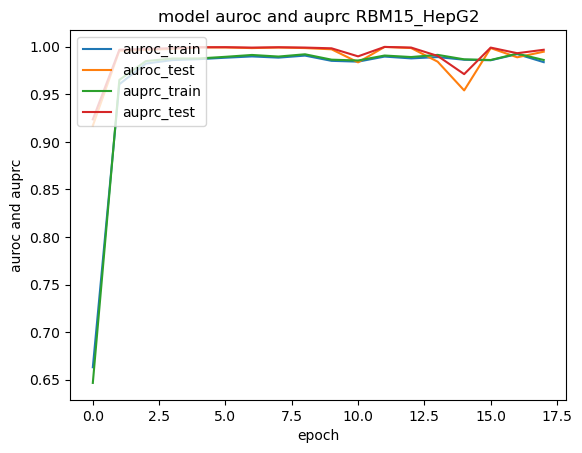

INFO:tensorflow:Assets written to: best_models/best_model_settingA_new_augRBM15_HepG2/assets


INFO:tensorflow:Assets written to: best_models/best_model_settingA_new_augRBM15_HepG2/assets


60/60 [==============================] - 0s 2ms/step
Prediction saved.


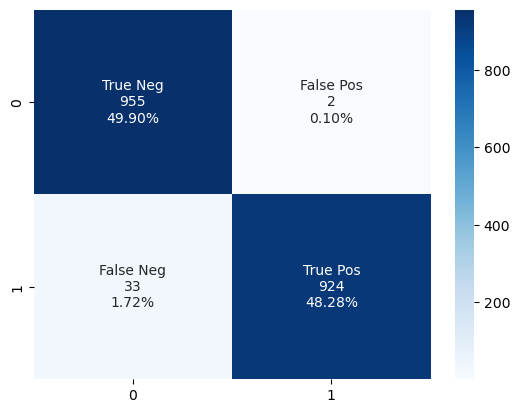

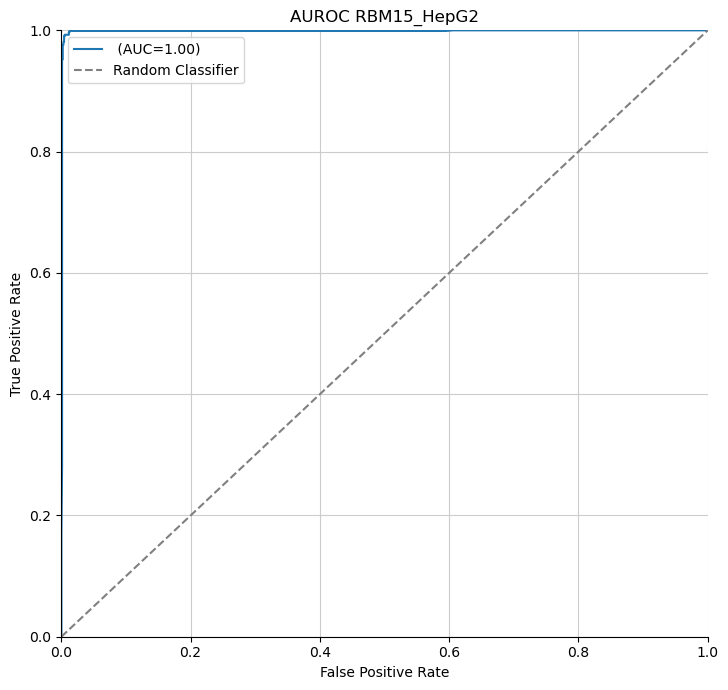

In [19]:
#Preparation of the dataset for setting A with bound and unbound sequences ( pos and neg1) 

path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
#folder = 'AARS_K562'
directory1 = os.listdir(path)




for folder in directory1:
    #if folder in ['AARS_K562', 'AATF_K562', 'BCF1_K562', 'AGGF1_HepG2', 'AGGF1_K562', 'AKAP1_HepG2']:
    #if folder in ['PABPC4_K562', 'PUM2_K562', 'IGF2BP3_K562', 'SUB1_HepG2', 'RBM15_K562', 'RBM15_HepG2']: #these are RBPs with high methylation rates
    if folder == 'RBM15_HepG2':    
        #getting first the onehot_enconded files 
        pos,neg1,pos_t,neg1_t = prepare_raw_dataset_m6A(path, folder)

        #preparing the files and labels following the setting A rules 
        pos_filt, neg1_filt, pos_t_filt, neg1_t_filt, labels_pos, labels_neg1, labels_pos_t, labels_neg1_t = settingA(pos,neg1,pos_t,neg1_t)


        #finalizing the dataset merging positive and the chosen negative ( either unbound - neg1- or bound to other RBPs -neg2- )
        x_train ,y_train ,x_val ,y_val ,x_test ,y_test = finalize_dataset(folder, pos_filt, neg1_filt, pos_t_filt, neg1_t_filt, labels_pos, labels_neg1, labels_pos_t, labels_neg1_t)
        
        #creating the baseline model with the right input shape 
        model = create_baseline_model(input_shape = (400, 5))
                
        #training the model on the new datasets
        y_labels = np.reshape(y_train, (len(y_train), ))
        from sklearn.utils import compute_class_weight
        class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y_labels), y = y_labels)
        class_weights = dict(zip(np.unique(y_train), class_weights))

        training_model(model, class_weights, x_train ,y_train ,x_val ,y_val ,x_test ,y_test, folder) #trains the model with best hyperparameters 
        
        
        #evaluation and storage of the predicted labels
        model_path = ('best_models/best_model_settingA_new_aug%s' %folder)
        testing_model(model_path , folder, x_test, y_test)
        
        
        